[53 语言模型](https://www.bilibili.com/video/BV1ZX4y1F7K3/?spm_id_from=333.788.recommend_more_video.0)
- 对于给定的文本序列$x_1,x_2,...x_T$，语言模型的目标是估计联合概率$p(x_1,x_2,...x_T)$
- 用于做预训练模型（BERT，GPT-3）
- 生成文本，给定前面几个词，不断的使用$(x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1))$来生成后续文本
- 预判哪个序列更加常见

- 这里，我们假设训练数据集是一个大型的文本语料库。 比如，维基百科的所有条目、 古登堡计划， 或者所有发布在网络上的文本。 训练数据集中词的概率可以根据给定词的相对词频来计算。 例如，可以将估计值$(\hat{P}(\text{deep}))$ 计算为任何以单词“deep”开头的句子的概率。 一种（稍稍不太精确的）方法是统计单词“deep”在数据集中的出现次数， 然后将其除以整个语料库中的单词总数。 这种方法效果不错，特别是对于频繁出现的单词。 接下来，我们可以尝试估计:
    - $[\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},]$
- 因此我们可以采用计数的方式来生成上述概率模型
- <img src="picture/屏幕截图 2022-05-29 211813.png">


- 显然，当序列长度足够大的时候，上述做法会导致计算量非常大，这时候可以采用马尔科夫假设来解决
- <img src="picture/屏幕截图 2022-05-29 213221.png">
- 在讨论包含深度学习的解决方案之前，我们需要了解更多的概念和术语。 回想一下我们在 8.1节中对马尔可夫模型的讨论， 并且将其应用于语言建模。 如果$(P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t))$， 则序列上的分布满足一阶马尔可夫性质。 阶数越高，对应的依赖关系就越长。 这种性质推导出了许多可以应用于序列建模的近似公式：

- (8.3.6)$$[\begin{split}\begin{aligned} P(x_1, x_2, x_3, x_4) &= P(x_1) P(x_2) P(x_3) P(x_4),\\ P(x_1, x_2, x_3, x_4) &= P(x_1) P(x_2 \mid x_1) P(x_3 \mid x_2) P(x_4 \mid x_3),\\ P(x_1, x_2, x_3, x_4) &= P(x_1) P(x_2 \mid x_1) P(x_3 \mid x_1, x_2) P(x_4 \mid x_2, x_3). \end{aligned}\end{split}]$$
通常，涉及一个、两个和三个变量的概率公式分别被称为 “一元语法”（unigram）、“二元语法”（bigram）和“三元语法”（trigram）模型。 下面，我们将学习如何去设计更好的模型。

In [97]:
import random
import torch
from d2l import torch as d2l

In [98]:
tokens = d2l.tokenize(d2l.read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [99]:
corpus[:10]

['the', 'time', 'machine', 'by', 'h', 'g', 'wells', 'i', 'the', 'time']

虽然是频率最高的词，但这些词显然没有包含太多的信息，因此这些词也被称为停用词（stop words），因此可以被过滤掉。 尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。 此外，还有个明显的问题是词频衰减的速度相当地快。 例如，最常用单词的词频对比，第$(10)个还不到第(1)个的(1/5)$。 为了更好地理解，我们可以画出的词频图：

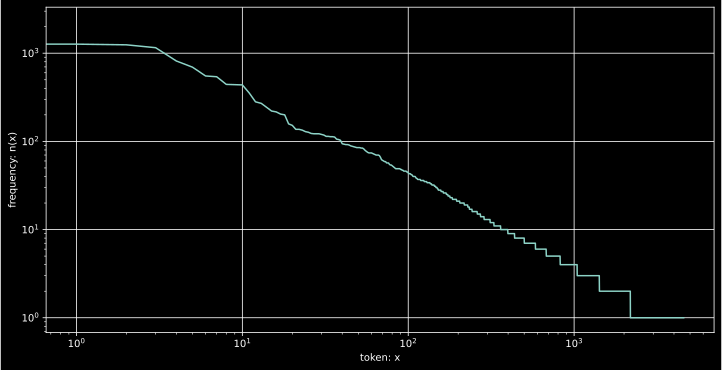

In [100]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', 
         yscale='log',
         figsize=(12,6)
         )

In [101]:
# 错位zip，构建二元序列
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [102]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

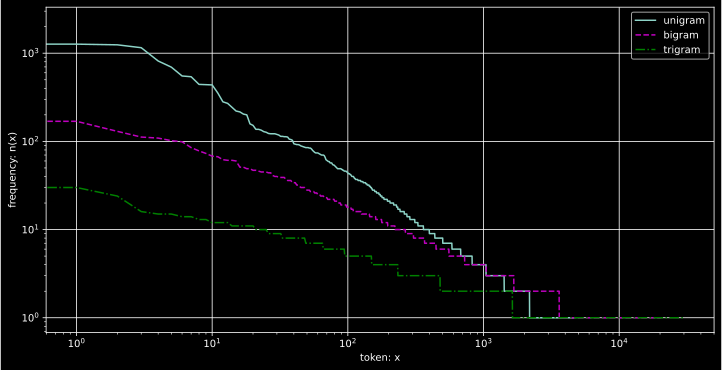

In [103]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'],figsize=(12,6))

- 由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。 之前的序列模型中以一种相当特别的方式做到了这一点： 当序列变得太长而不能被模型一次性全部处理时， 我们可能希望拆分这样的序列方便模型读取。

- 假设将使用神经网络来训练语言模型， 模型中的网络一次处理具有预定义长度 （例如\(n\)个时间步）的一个小批量序列。 现在的问题是如何随机生成一个小批量数据的特征和标签以供读取。

<img src = "picture/微信图片_20220530235817.png">
- 为了应对上述现象：下面这种方式是随机在[0,n]之间（n元序列）选取一个数值k，然后从第k个开始作为起点，去n元序列

In [104]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列
        corpus : 词汇表的下标
        num_steps : 选取的n元序列长度
    """
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    print(f'选取的为{num_steps}元序列')
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
    # initial_indices就是序列的起始点
    print('选取序列下标为',initial_indices)
    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        print('单个batch_size选取下标为',initial_indices_per_batch,end='\n\n')
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        # x为训练数据，y为预测数据，这里y与x差距为1，可以等同于序列模型中的tau=1
        yield torch.tensor(X), torch.tensor(Y)

In [105]:
# 这里只是做演示
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


选取的为5元序列
选取序列下标为 [15, 5, 25, 0, 20, 10]
单个batch_size选取下标为 [15, 5]

X:  tensor([[19, 20, 21, 22, 23],
        [ 9, 10, 11, 12, 13]]) 
Y: tensor([[20, 21, 22, 23, 24],
        [10, 11, 12, 13, 14]])
单个batch_size选取下标为 [25, 0]

X:  tensor([[29, 30, 31, 32, 33],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[30, 31, 32, 33, 34],
        [ 5,  6,  7,  8,  9]])
单个batch_size选取下标为 [20, 10]

X:  tensor([[24, 25, 26, 27, 28],
        [14, 15, 16, 17, 18]]) 
Y: tensor([[25, 26, 27, 28, 29],
        [15, 16, 17, 18, 19]])


In [106]:
# 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [107]:
# 从输出结果可以看出，输出的序列是不断连续的输出
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [108]:
# 将上面的两个采样函数包装到一个类中， 以便稍后可以将其用作数据迭代器。
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)